In [1]:
"""
http://www.nlpr.ia.ac.cn/cip/yubochen/yubochenPageFile/acl2015chen.pdf
https://zhuanlan.zhihu.com/p/60498216
"""
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm


c:\Users\Xunjing\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

df = pd.read_csv('GOOG-year.csv')
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32'))
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32'))
df_log = pd.DataFrame(df_log)
test_size = 30
simulation_size = 10
# 拆分成测试集和训练集
df_train = df_log.iloc[:-test_size]
df_test = df_log.iloc[-test_size:]
# 在这里调参
num_layers = 1
size_layer = 128
kernel_size = 3
epoch = 1000
dropout_rate = 0.7
learning_rate = 1e-3

In [3]:
tf.compat.v1.disable_eager_execution()


class Model:
    """
    CNN model with optimizer Adam
    Activation function is ReLU
    """

    def __init__(self, learning_rate, num_layers, size, size_layer, output_size, n_attn_heads=16, dropout=0.9):
        # Placeholder for input and output
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))

        # Encoder layer
        encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)

        # Multiple layers with dropout and ReLU activation
        for _ in range(num_layers):
            encoder_embedded = self.layer(encoder_embedded, size_layer * 2, dropout)

        # Apply ReLU activation to the last output
        encoder_embedded = tf.nn.relu(encoder_embedded[-1])

        # Output layer
        self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)

        # Loss and optimizer
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(self.cost)

    def layer(self, input_layer, size, dropout):
        """
        Custom layer function with dropout and ReLU activation
        """
        z = tf.compat.v1.layers.dense(input_layer, size)
        z = tf.nn.dropout(z, rate=dropout)
        return tf.nn.relu(z)


def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

In [4]:

def forecast():
    """
    Train a neural network model and return the forecasted stock prices for the next 30 days.
    """
    tf.compat.v1.reset_default_graph()

    # Initialize a neural network model
    modelnn = Model(learning_rate, num_layers, df_train.shape[1], size_layer, df_train.shape[1], dropout=dropout_rate)

    # Initialize a TensorFlow session
    with tf.compat.v1.Session() as sess:
        sess.run(tf.compat.v1.global_variables_initializer())

        # Training loop
        pbar = tqdm(range(epoch), desc='train loop')
        for i in pbar:
            total_loss, total_acc = [], []

            # Process data in batches of 30 consecutive days
            for k in range(0, df_train.shape[0] - 1, 30):
                index = min(k + 30, df_train.shape[0] - 1)
                batch_x = np.expand_dims(df_train.iloc[k:index, :].values, axis=0)
                batch_y = df_train.iloc[k + 1:index + 1, :].values

                logits, _, loss = sess.run([modelnn.logits, modelnn.optimizer, modelnn.cost],
                                           feed_dict={modelnn.X: batch_x, modelnn.Y: batch_y})

                total_loss.append(loss)
                total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))

            pbar.set_postfix(cost=np.mean(total_loss), acc=np.mean(total_acc))

        # Forecasting
        future = 30
        output_predict = np.zeros((df_train.shape[0] + future, df_train.shape[1]))
        output_predict[0] = df_train.iloc[0]
        upper_b = (df_train.shape[0] // 30) * 30

        # Generate predictions for the existing data
        for k in range(0, (df_train.shape[0] // 30) * 30, 30):
            out_logits = sess.run(modelnn.logits, feed_dict={modelnn.X: np.expand_dims(df_train.iloc[k:k + 30], axis=0)})
            output_predict[k + 1:k + 30 + 1] = out_logits

        # Generate predictions for the remaining data
        if upper_b != df_train.shape[0]:
            out_logits = sess.run(modelnn.logits, feed_dict={modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis=0)})
            output_predict[upper_b + 1:df_train.shape[0] + 1] = out_logits
            future -= 1

        # Generate predictions for the future
        num = 0
        while num < future:
            o = output_predict[-future - 30 + num:-future + num]
            out_logits = sess.run(modelnn.logits, feed_dict={modelnn.X: np.expand_dims(o, axis=0)})
            output_predict[-future + num] = out_logits[-1]
            num += 1

    # Inverse transform the predictions to original scale
    output_predict = minmax.inverse_transform(output_predict)

    # Apply smoothing to the predictions
    buffer = []
    last = output_predict[:, 0][0]
    for i in output_predict[:, 0]:
        smoothed_val = last * 0.3 + (1 - 0.3) * i
        buffer.append(smoothed_val)
        last = smoothed_val

    # Return the forecasted values for the test period
    return buffer[-test_size:]

results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1



C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


train loop: 100%|██████████| 1000/1000 [00:09<00:00, 111.03it/s, acc=96.5, cost=0.00254]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 2


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 114.58it/s, acc=96.5, cost=0.00266]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 3


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 115.96it/s, acc=96.4, cost=0.00291]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 4


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 122.47it/s, acc=96.3, cost=0.00322]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 5


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 113.15it/s, acc=96.6, cost=0.00244]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 6


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 118.42it/s, acc=96.2, cost=0.00319]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 7


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 115.17it/s, acc=95.9, cost=0.00375]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 8


train loop: 100%|██████████| 1000/1000 [00:08<00:00, 120.13it/s, acc=96.3, cost=0.00295]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 9


train loop: 100%|██████████| 1000/1000 [00:09<00:00, 104.22it/s, acc=96.5, cost=0.0027]
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:16: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  encoder_embedded = tf.compat.v1.layers.dense(self.X, size_layer)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:36: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  z = tf.compat.v1.layers.dense(input_layer, size)
C:\Users\Xunjing\AppData\Local\Temp/ipykernel_30832/3538512307.py:26: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.logits = tf.compat.v1.layers.dense(encoder_embedded, output_size)


simulation 10


train loop: 100%|██████████| 1000/1000 [00:10<00:00, 95.60it/s, acc=96.3, cost=0.00333]


max accuracy: 97.6409
average accuracy: 94.6940


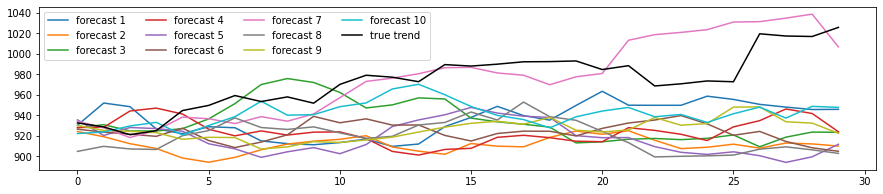

In [15]:
accuracies = [calculate_accuracy(df['Close'].iloc[-test_size:].values, r) for r in results]
plt.figure(figsize = (15, 3))
count = 0
for no, r in enumerate(results):
    # if accuracies[no] >= np.mean(accuracies):
        plt.plot(r, label = 'forecast %d'%(no + 1))
# print('max number: %.4f'%(i))
print('max accuracy: %.4f'%(np.max(accuracies)))
print('average accuracy: %.4f'%(np.mean(accuracies)))
plt.plot(df['Close'].iloc[-test_size:].values, label = 'true trend', c = 'black')
plt.legend(loc='best',ncol=4)
plt.show()